In [1]:
import numpy as np
import math
from numpy.random import normal
from typing import Optional, Union, Callable

import tensorflow as tf
tf.compat.v1.experimental.output_all_intermediates(True)
from tensorflow.keras.layers import Dense, Input, LSTM, Layer, TimeDistributed, Lambda, Activation
from tensorflow.keras.initializers import Ones, Zeros
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import callbacks
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
# refer to # # https://www.kaggle.com/shujian/transformer-with-lstm
# define the multi-head transformer structure by hand
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self._eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self._gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self._beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self._gamma * (x - mean) / (std + self._eps) + self._beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self._temper = np.sqrt(d_model)
        self._dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self._temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self._dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn


class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, num_head, dim_model, dim_key, dim_value, dropout, mode=0, use_norm=True):
        self._head_mode = mode
        self._num_head = num_head
        self._dim_key = dim_key
        self._dim_value = dim_value
        self._dropout = dropout
        if self._head_mode == 0:
            self.qs_layer = Dense(num_head*dim_key, use_bias=False)
            self.ks_layer = Dense(num_head*dim_key, use_bias=False)
            self.vs_layer = Dense(num_head*dim_value, use_bias=False)
        elif self._head_mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(num_head):
                self.qs_layers.append(TimeDistributed(Dense(dim_key, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(dim_key, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(dim_value, use_bias=False)))
        self.attention = ScaledDotProductAttention(dim_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(dim_model))


    def __call__(self, q, k, v, mask=None):
        from keras.layers import Concatenate
        if self._head_mode == 0:
            qs = self.qs_layer(q) 
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                shape = tf.shape(x) 
                x = tf.reshape(x, [shape[0], shape[1], self._num_head, self._dim_key])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, shape[1], self._dim_key])
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, self._num_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                shape = tf.shape(x)
                x = tf.reshape(x, [self._num_head, -1, shape[1], shape[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, shape[1], self._num_head*self._dim_value])
                return x
            head = Lambda(reshape2)(head)
        elif self._head_mode == 1:
            heads = []; attns = []
            for i in range(self._num_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if self._num_head > 1 else heads[0]
            attn = Concatenate()(attns) if self._num_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self._dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn


In [3]:
from keras.layers import GlobalMaxPooling1D, Flatten, GlobalAveragePooling1D, Reshape, concatenate
class Transformer:
    def __init__(self, win_len, input_dim, hidden_dim=[128,64], attn_mode=0, head_mode=0):
        self.name = 'Transformer'
        self._win_len = win_len
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        # if attn_mode = 1, it will deploy the handmade multihead attention layer
        # if attn_mode = 0, it will deploy the keras multihead attention layer
        self._attn_mode = attn_mode
        self._head_mode = head_mode
    

    # 需要 loss function
    def _build_loss(self, sigma: tf.Tensor) -> Callable:

        def gaussian_likelihood(y_true, y_pred):
            return tf.reduce_mean(
                tf.math.log(tf.math.sqrt(2 * math.pi))
                + tf.math.log(sigma)
                + tf.math.truediv(
                    tf.math.square(y_true - y_pred), 2 * tf.math.square(sigma)
                )
            )
            
        return gaussian_likelihood

    def build_and_compile(self) -> None:
        inputs = Input(shape=(self._win_len, self._input_dim))
        lstm_out1 = LSTM(self._hidden_dim[0], return_sequences=True)(inputs)
        x = LSTM(self._hidden_dim[1], return_sequences=True)(lstm_out1) 
        if self._attn_mode == 1:
          x, slf_attn = MultiHeadAttention(num_head=3, dim_model=300, 
                                           dim_key=self._hidden_dim[1], 
                                           dim_value=self._hidden_dim[1], 
                                           dropout=0.1, 
                                           mode=self._head_mode)(x, x, x)
        elif self._attn_mode == 0:
          x, slf_attn = layers.MultiHeadAttention(
                num_heads=3,
                key_dim=self._hidden_dim[1],
                value_dim=self._hidden_dim[1],
                dropout=0.1)(x, x, x,
                return_attention_scores=True)
        else:
          print('Wrong attn_mode input. Attention layer will not be deployed.')
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        dense = Dense(self._hidden_dim[1], activation="relu")(conc)
        dense_out = Dense(self._input_dim)(dense)      

        model = Model(inputs=inputs, outputs=dense_out)

        model.compile(
            loss='mse',
            metrics=['mse'],
        )

        self._model = model

    def get_model(self) -> Model:
        return self._model

    def summary(self) -> None:
        self._model.summary()

    def fit(self, **kwargs) -> None:
        self._model.fit(**kwargs)

    def predict(self, X_test):
        return self._model.predict(X_test)


In [4]:
import sys
from google.colab import drive
drive.mount('/content/drive')
# to use the packages in google drive
sys.path.append('/content/drive/My Drive/6000M_proj2/proj2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU, LSTM, BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis
from os.path import join

from config import *

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse

In [7]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16
training_path = Path(join(data_path, 'train_set'))
ret_train = pd.read_csv(join(training_path, '2022-03-31.csv'), index_col=0)
X, y = time_series_generator(ret_train, WIN_LEN)
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378, 30, 2500), (126, 30, 2500), (378, 2500), (126, 2500))

In [8]:
transformer_api_matrix = Transformer(30, 2500, [128, 64], attn_mode=0, head_mode=0)
transformer_hand_matrix = Transformer(30, 2500, [128, 64], attn_mode=1, head_mode=0)
transformer_hand_timedis = Transformer(30, 2500, [128, 64], attn_mode=1, head_mode=1)

In [9]:
transformer_api_matrix.build_and_compile()
transformer_hand_matrix.build_and_compile()
transformer_hand_timedis.build_and_compile()

In [10]:
transformer_api_matrix.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),)

Train on 378 samples, validate on 126 samples
Epoch 1/20
378/378 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


378/378 [==============================] - 8s 21ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/20
378/378 [==============================] - 6s 16ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
378/378 [==============================] - 8s 20ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/20
378/378 [==============================] - 6s 16ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/20
378/378 [==============================] - 8s 21ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/20
378/378 [==============================] - 6s 16ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/20
378/378 [==============================] - 6s 16ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/20
378/378 [==============================] - 3s 9ms/sampl

In [11]:
transformer_hand_matrix.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),)

Train on 378 samples, validate on 126 samples
Epoch 1/20
378/378 [==============================] - 5s 12ms/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/20
378/378 [==============================] - 4s 10ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/20
378/378 [==============================] - 4s 12ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/20
378/378 [==============================] - 3s 9ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/20
378/378 [==============================] - 3s 8ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/20
378/378 [==============================] - 4s 11ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/20
378/378 [==============================] - 4s 11ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/20


In [12]:
transformer_hand_timedis.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),)

Train on 378 samples, validate on 126 samples
Epoch 1/20
378/378 [==============================] - 7s 17ms/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/20
378/378 [==============================] - 3s 9ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/20
378/378 [==============================] - 3s 9ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 4/20
378/378 [==============================] - 5s 13ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/20
378/378 [==============================] - 4s 10ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/20
378/378 [==============================] - 3s 9ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/20
378/378 [==============================] - 3s 9ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/20
37

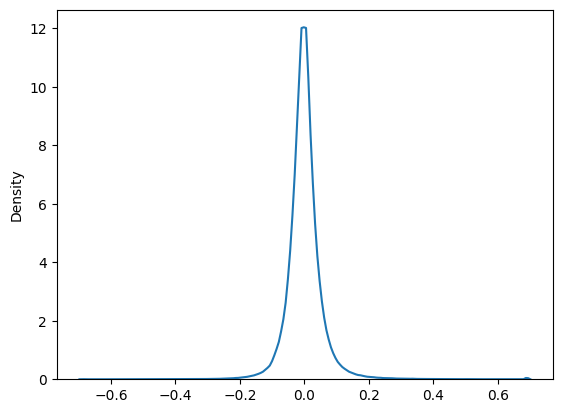

In [13]:
training_path = Path(join(data_path, 'train_set'))
liquid_ticker_ret = pd.read_csv(join(training_path, 'liquid_ticker_ret.csv'), index_col=0)
ret_train = liquid_ticker_ret.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS-WIN_LEN:]
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
train_flat = ret_train.values.flatten()
train_flat = train_flat[train_flat != 0]
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-2*s, m+2*s)
sns.kdeplot(train_flat)
## get ticker returns
test_start_date = liquid_ticker_ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
ret_test = liquid_ticker_ret.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN+1]
ret_test = ret_test.clip(m-2*s, m+2*s)
X_test, y_test = time_series_generator(ret_test, WIN_LEN)

In [14]:
y_pred_test_api_matrix = transformer_api_matrix.predict(X_test)
y_pred_test_hand_matrix = transformer_hand_matrix.predict(X_test)
y_pred_test_hand_timedis = transformer_hand_timedis.predict(X_test)


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [15]:
from src.metrics import plot_mse, generate_report
generate_report(
    [y_pred_test_api_matrix, y_pred_test_hand_matrix, y_pred_test_hand_timedis], y_test, 
    ['transformer_api', 'handmade_attention_matrix_form', 'handmade_attention_time_distributed_form']
)

,mse,corr,deviation
transformer_api,0.002658,0.043304,1.065924
handmade_attention_matrix_form,0.002770,0.000387,1.146424
handmade_attention_time_distributed_form,0.003004,0.000743,1.213847
